
# Allstate Car Insurance Online Purchase Prediction

Author: Kemei Zhuo

Note: this work is built upon my class group project. My group members are Alyson Brown, Teeru Gupta, Jihyun Lee. Below I summarized my work and what I explored after this project.

### Summary: 

Given a customer's shopping history, what type of insurance would this customer purchase in the end? 

Through Exploratory Data Analysis, I found that first, most customers would purchase the insurance within one day, and the majority of them would buy insurance during weekdays, especially on Friday; second, the types of insurance products are correlated with each other (type C and D); third, customers would buy the insurance types that they searched the most and they recently looked at; fourth, price change is not a significant predictor of purchasing for every customer. After Exploratory Data Analysis, I used classification models such as k-nearest neighbors, naivebayes, and random forest to predict the type of insurance the customer would purchase.  

The key takeaways for Allstate is: it needs to follow up the customers immediately because customers usually make purchases within a day. Allstate can use both demographic information and shopping history to predict the potential purchase and send follow-up emails to these customers with discounts. Allstate can also relocate its resources because most customers shop around during weekdays. 





### Our challenge:

    As a customer shops an insurance policy, he/she will get a quote with selected coverage many times before he/she actually makes a purchase. Given the information about the customer, information about the quoted policy, and the quoted price, Allstate is interested in knowing which policy would a customer purchase. Besides the prediction, we are also interested in knowing what collection of customers are buying each insurance product and how we can convert a shopper into a purchaser. 
    


### Dataset Description

In [6]:
import pandas as pd
df = pd.read_csv('train.csv', sep=',')

In [7]:
df[9:15]

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
9,10000005,1,0,3,8:56,NY,10006,1,0,10,...,3.0,13.0,1,1,3,3,1,0,2,755
10,10000005,2,0,3,8:56,NY,10006,1,0,10,...,3.0,13.0,1,1,3,3,1,0,2,755
11,10000005,3,0,3,8:57,NY,10006,1,0,10,...,3.0,13.0,1,1,3,3,1,0,2,755
12,10000005,4,0,3,8:58,NY,10006,1,0,10,...,3.0,13.0,0,0,3,2,0,0,2,730
13,10000005,5,0,3,8:58,NY,10006,1,0,10,...,3.0,13.0,0,0,3,2,0,0,2,731
14,10000005,6,1,3,9:09,NY,10006,1,0,10,...,3.0,13.0,0,0,3,2,0,0,2,731



The above table is a compete shopping history of a customer labeled as 10000005. 

The variables are described below:

    customer_ID - A unique identifier for the customer

    shopping_pt - Unique identifier for the shopping point of a given customer

    record_type - 0=shopping point, 1=purchase point

    day - Day of the week (0-6, 0=Monday)

    time - Time of day (HH:MM)

    state - State where shopping point occurred

    location - Location ID where shopping point occurred

    group_size - How many people will be covered under the policy (1, 2, 3 or 4)

    homeowner - Whether the customer owns a home or not (0=no, 1=yes)

    car_age - Age of the customer’s car

    car_value - How valuable was the customer’s car when new

    risk_factor - An ordinal assessment of how risky the customer is (1, 2, 3, 4)

    age_oldest - Age of the oldest person in customer's group

    age_youngest - Age of the youngest person in customer’s group

    married_couple - Does the customer group contain a married couple (0=no, 1=yes)

    C_previous - What the customer formerly had or currently has for product option C (0=nothing, 1, 2, 3,4)

    duration_previous -  how long (in years) the customer was covered by their previous issuer

    A,B,C,D,E,F,G - the coverage options

    cost - cost of the quoted coverage options

Note here that the A,B,C,D,E,F,G coverage options have different possible values. 

Option name       |      Possible values

A                 |      0, 1, 2

B                 |      0, 1

C                 |      1, 2, 3, 4

D                 |      1, 2, 3

E                 |      0, 1

F                 |      0, 1, 2, 3

G                 |      1, 2, 3, 4

The number of customers: 

In [8]:
num_customer = sum(df['record_type']==1)
num_customer

97009

Some columns of the datasets have many NA values.

In [9]:
sum(df['car_value'].isna())

1531

In [10]:
sum(df['risk_factor'].isna())

240418

In [11]:
sum(df['C_previous'].isna())

18711

In [12]:
sum(df['duration_previous'].isna())

18711

### Exploratory Data Analysis

In [2]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### (1) Shopping_pts
Let's first take a look at the "shopping_pt". Most people would have 7 or 8 shopping points. The minimum shopping_pts here is 3, which means that customer would get quotes at least 3 times before they finally made a purchase. 

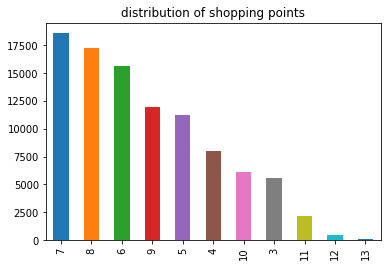

In [3]:
mask = df['record_type']==1
df[mask]['shopping_pt'].value_counts().plot(kind="bar", title="distribution of shopping points")

I first looked at the relationship between shopping_pt and location and expected that maybe people in one place took more time on collecting information before they made a decision.

However, from the plot "length of shopping_pt of customers in different states" below: we can see that there's not much differece on length of shopping points in different states.

Text(0.5,1,'length of shopping_pt of customers in different states')

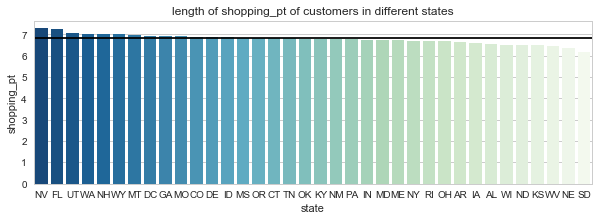

In [13]:
# check purchase point
mask = df['record_type']==1
# groupby the data by state
temp = df[mask].groupby('state')[['shopping_pt']].mean().sort_values(by='shopping_pt', ascending=False)
x = temp.index
y = temp['shopping_pt']
# average shopping points
avg_shoppts = df.groupby('customer_ID')['shopping_pt'].count().sum() * 1.0 /  num_customer
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x, y, palette="GnBu_r", ax=ax)
plt.axhline(y=avg_shoppts, color="black")
plt.title("length of shopping_pt of customers in different states")

#### (2) day 
Then I visualized the variable "day" and wondered what would be the time difference between the point when the customer got the first quoted price and the point when he/she made the purchase. Sometimes the customer needs the car insurance the very next day if he/she plans to buy a car. From the plot "within x day(s) the customers made the purchase" we can see that most customers made the purchase on the same day. This tells us that the company should act fast and pay attention to the customer when he/she made the first quote. 

In [7]:
mask = (df['record_type'] == 1) | (df['shopping_pt']==1) 
temp = df[mask].groupby(['customer_ID', 'day'])[['day']].count().unstack()
def cal_diff(s):
    ''' the difference between the first shopping point and the last shopping point'''
    if s.max() > 1:# purchase made on the same day
        s['d'] = 1
    else: # purchase made on different days
        s_index = s[s==1]['day'].index
        s['d'] =  s_index[1] -  s_index[0]
    return s['d']
diff_day = temp.apply(cal_diff, axis=1)

Text(0.5,1,'within x day(s) the customers made the purchase')

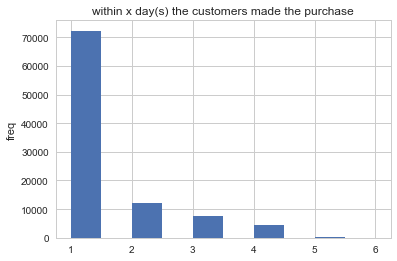

In [8]:
diff_day.hist()
ylabel("freq")
title("within x day(s) the customers made the purchase")

Here I visualized the variable "day" to see at which day customers were shopping and purchasing. If we can find out that the customers shop and purchase at a certain day or time, the company can relocate its resources, better serves its customers, and possibly get more sales.  

From the plot "at which day customers are shopping and purchasing" below, we can see a peak at Friday for purchasing. In addition, we can see that lots of customers were shopping and purchasing during weekdays; relatively few people shop around during weekends. 

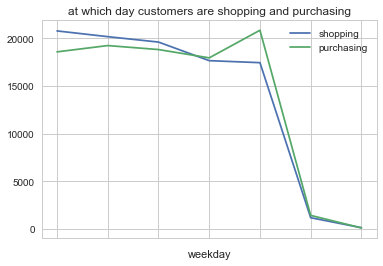

In [9]:
# shopping
index = df[mask]['record_type'] == 0
df[mask][index].groupby(['customer_ID', 'day'])[['day']].count().unstack().sum(axis=0).plot(kind='line', label="shopping")
# purchasing
index = df[mask]['record_type'] == 1
df[mask][index].groupby(['customer_ID', 'day'])[['day']].count().unstack().sum(axis=0).plot(kind='line', label="purchasing")
xlabel("weekday")
title("at which day customers are shopping and purchasing")
legend(numpoints=1, loc='best')

#### (3) Insurance Type



Let's look at the distribution of each insurance type. We can see that every distribution is right skewed. 

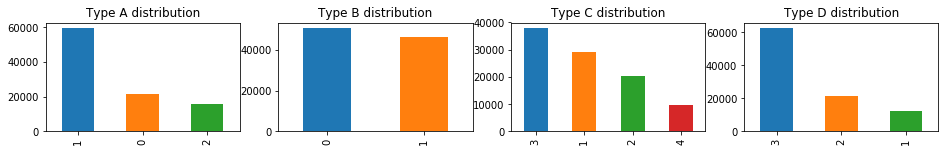

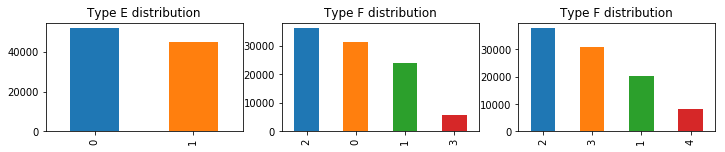

In [205]:
f, axes = plt.subplots(1, 4, sharey=False, figsize=(16, 2))
mask = df['record_type']==1
df[mask]['A'].value_counts().plot(kind="bar", ax=axes[0], title="Type A distribution")
df[mask]['B'].value_counts().plot(kind="bar", ax=axes[1], title="Type B distribution")
df[mask]['C'].value_counts().plot(kind="bar", ax=axes[2], title="Type C distribution")
df[mask]['D'].value_counts().plot(kind="bar", ax=axes[3], title="Type D distribution")
f, axes = plt.subplots(1, 3, sharey=False, figsize=(12, 2))
df[mask]['E'].value_counts().plot(kind="bar", ax=axes[0], title="Type E distribution")
df[mask]['F'].value_counts().plot(kind="bar", ax=axes[1], title="Type F distribution")
df[mask]['G'].value_counts().plot(kind="bar", ax=axes[2], title="Type G distribution")


Here I looked at the correlation between each type of insurance. We can see that the type C and type D has a medium correlation of 0.61; type A and F has a correlation of 0.53.

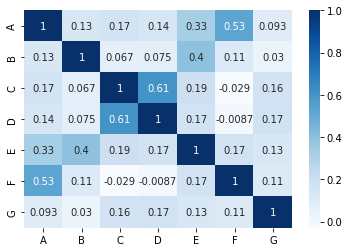

In [16]:
mask = df['record_type']==1
corr_type = df[mask][['A', 'B', 'C', 'D', 'E', 'F', 'G']].corr()
sns.heatmap(corr_type, annot=True, cmap="Blues")

Here I combined all the insurance type into one column "combine". I'm interested to see whether the customer bought the insurance product that he/she searched the most. The answer is Yes. From the plot below, more than 60% of customers actually did purchase what they looked at the most.

Text(0.5,1,'would customers purchase the policy that they looked most times?')

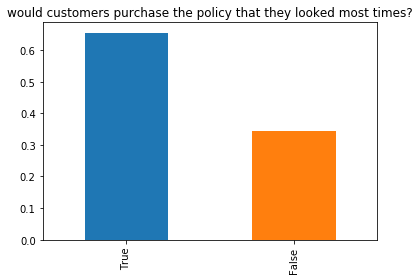

In [15]:
# combine types of insurance
df['combine'] = df['A'].astype(str) + df['B'].astype(str) + df['C'].astype(str) + df['D'].astype(str) + df['E'].astype(str) + df['F'].astype(str) + df['G'].astype(str)
# summarize the combined insurance and count the number of search. 
d1 = df.groupby(['customer_ID', 'combine'])[['combine']].count()
# d2 has two columns: customer ID and the combined insruance which is searched the most
d2 = d1.unstack('combine').T.reset_index().set_index('combine')
d2 = pd.DataFrame(d2.drop(columns='level_0').idxmax())
d2.columns = ['combine']
d2.reset_index(inplace=True)
# select has two columns: customer ID and the combined insruance bought 
index = df['record_type'] == 1
select = df[index][['customer_ID', 'combine']].reset_index().drop(columns='index')
# merge two dataset: d2 and select
new_data = d2.merge(select, left_on='customer_ID', right_on='customer_ID', suffixes=['_most', '_chosen'])
# if the one searched the most and the one bought matched, then return true
new_data['is'] = new_data['combine_most'] == new_data['combine_chosen']
(new_data['is'].value_counts()/num_customer).plot(kind='bar')
title('would customers purchase the policy that they looked most times?')

I'm also interested in recency effect. Does a customer tend to buy things that he searched just recently? I looked at the last two shopping points and wanted to compare the insurance type at these two points. From the plot below, we can see that a majority of customers (a little below 70%) would buy the insurance product that they looked at one shopping point before purchase. 

Text(0.5,1,'Does the customer buy insurance that he/she just searched recently?')

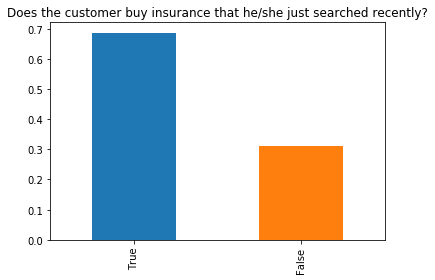

In [86]:
# take out the last two shopping points for all customers
mask = df['record_type'] == 1
temp = df[mask.shift(-1) | mask]
temp1 = temp.groupby(['customer_ID', 'combine'])[['combine']].count()
temp2 = (temp1['combine']==2).value_counts()
temp2[0] = num_customer - sum(temp1['combine']==2)
(temp2/num_customer).plot(kind="bar")
title("Does the customer buy insurance that he/she just searched recently?")

#### (4) Price

Here I paid close attention to the last two shopping points. What could be the reason that the customer made the decision to purchase? They were tired of quoting? Maybe the price is acceptable at the last two points? 

By comparing the price difference at the last two shopping points given the same insusrance combination, we can see that difference concertrates near zero. The odd part is that several people made the purchase after the price went up by over $100. Remember, this is the same insurance product. Maybe these people are super rich?   



Text(0.5,1,'The price change of the same insurance type at the last two shopping_pts')

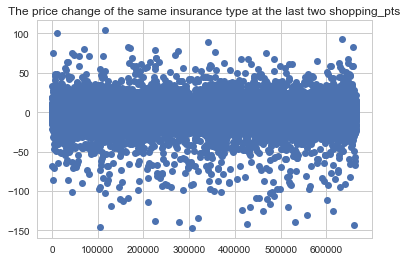

In [17]:
mask1 = df['record_type'] == 1
mask_merged = mask1.shift(-1).fillna(True) | mask1
df1 = df[mask_merged]
check_combine = [None] * len(df1)
for i in [x * 2 for x in range(len(df1)/2)]:
    if df1.iloc[i]['combine'] == df1.iloc[i+1]['combine']:
        check_combine[i] = True
        check_combine[i+1] = True
    else:
        check_combine[i] = False
        check_combine[i+1] = False
check_combine_diff = [not i for i in check_combine]
diff_cost = df1[check_combine].groupby(['customer_ID'])[['cost']].diff().dropna()
diff_cost_diff = df1[check_combine_diff].groupby(['customer_ID'])[['cost']].diff().dropna()
# when people buy the policy, does the price drop compared to the previous quote if they checked the same policy?
plot(diff_cost, marker='o', linestyle='None')
title('The price change of the same insurance type at the last two shopping_pts')

####  Data Cleaning

Because there's so many NA values in risk_factor, car_value, C_previous, and duration_previous, I decided to drop the NA values. I also transformed the value of "car_value" from a,b,c,d,.. to 1,2,3,4..

In [14]:
mask1 = df['record_type'] == 1
temp = df[mask1].copy()
temp.dropna(inplace=True)
temp['car_value'] = temp['car_value'].map(ord) - 96
X = temp[['location', 'group_size', 'homeowner', 'car_age', 'car_value', 'risk_factor', 'age_oldest', 'married_couple', 'C_previous', 'duration_previous', 'cost']]
Y = temp[['A', 'B', 'C', 'D', 'E', 'F', 'G']]

I will use the following X to train a knn model. (I tried KNN, Naivebayes, and RandomForest. KNN has the best accuracy for all types prediction)

In [151]:
X[0:3]

,location,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,married_couple,C_previous,duration_previous,cost
8,10001,2,0,2,7,3.0,46,1,1.0,2.0,634
14,10006,1,0,10,5,4.0,28,0,3.0,13.0,731
26,10014,2,1,3,4,3.0,62,1,3.0,3.0,626


In [112]:
Y[0:3]

,A,B,C,D,E,F,G
8,1,0,2,2,1,2,1
14,0,0,3,2,0,0,2
26,1,1,3,2,1,1,3


#### Predictive Modeling

In [15]:
# package used
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

Let's fit a KNN model using every predictor in X. Just to show how bad the accuracy is. From the accuracy below, we can see that the demographic information has little prediction power. From the confusion matrix, we can see many zeros on the right side of the confusion matrix. One explanation would be that the data is right skewed as we can see from EDA. 


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['A'], test_size=0.2, random_state=12)
knn = neighbors.KNeighborsClassifier(n_neighbors=200, weights='uniform', p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print "Type A prediction"
print "accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(X, Y['B'], test_size=0.2, random_state=12)
knn = neighbors.KNeighborsClassifier(n_neighbors=200, weights='uniform', p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print "Type B prediction"
print "accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(X, Y['C'], test_size=0.2, random_state=12)
knn = neighbors.KNeighborsClassifier(n_neighbors=200, weights='uniform', p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print "Type C prediction"
print "accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(X, Y['D'], test_size=0.2, random_state=12)
knn = neighbors.KNeighborsClassifier(n_neighbors=200, weights='uniform', p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print "Type D prediction"
print "accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(X, Y['E'], test_size=0.2, random_state=12)
knn = neighbors.KNeighborsClassifier(n_neighbors=200, weights='uniform', p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print "Type E prediction"
print "accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(X, Y['F'], test_size=0.2, random_state=12)
knn = neighbors.KNeighborsClassifier(n_neighbors=200, weights='uniform', p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print "Type F prediction"
print "accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(X, Y['G'], test_size=0.2, random_state=12)
knn = neighbors.KNeighborsClassifier(n_neighbors=200, weights='uniform', p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print "Type G prediction"
print "accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type A prediction
accuracy 0.6610713998875593
[[ 152 2255    0]
 [  15 8079    0]
 [   3 1947    0]]
Type B prediction
accuracy 0.550879447433941
[[3952 2440]
 [3152 2907]]
Type C prediction
accuracy 0.4507268492490563
[[ 107    1 2685    0]
 [  50    1 2440    0]
 [  86    4 5504    0]
 [  18    2 1553    0]]
Type D prediction
accuracy 0.7146413942655209
[[   0    0 1035]
 [   0    0 2518]
 [   0    0 8898]]
Type E prediction
accuracy 0.6250100393542687
[[2973 3243]
 [1426 4809]]
Type F prediction
accuracy 0.4421331619950205
[[2234  276 1818    0]
 [ 865  402 1861    0]
 [1169  415 2869    0]
 [ 182   48  312    0]]
Type G prediction
accuracy 0.4310497148823388
[[  34 1061  962    0]
 [  23 2542 1929    0]
 [  22 1693 2791    0]
 [   8  538  848    0]]


However, if we only use the insurance type that the customer searched before they made a purchase, the accuracy will be more than 90%. Thus, we know that customer shopping history alone has more prediction power than his/her demographic information. 

In [17]:
import warnings
warnings.filterwarnings('ignore')
X_new = X.copy()
X_new['A_pre'] = df.iloc[X.index-1]['A'].values
X_new['B_pre'] = df.iloc[X.index-1]['B'].values
X_new['C_pre'] = df.iloc[X.index-1]['C'].values
X_new['D_pre'] = df.iloc[X.index-1]['D'].values
X_new['E_pre'] = df.iloc[X.index-1]['E'].values
X_new['F_pre'] = df.iloc[X.index-1]['F'].values
X_new['G_pre'] = df.iloc[X.index-1]['G'].values

Let's try Naivebayes here. 

In [18]:
X_A = X_new[['A_pre']]
Y_A = Y['A']
X_train, X_test, y_train, y_test = train_test_split(X_A, Y_A, test_size=0.25, random_state=12)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print "Type A prediction"
print metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_B = X_new[['B_pre']]
Y_B = Y['B']
X_train, X_test, y_train, y_test = train_test_split(X_B, Y_B, test_size=0.25, random_state=12)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print "Type B prediction"
print metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_C = X_new[['C_pre']]
Y_C = Y['C']
X_train, X_test, y_train, y_test = train_test_split(X_C, Y_C, test_size=0.25, random_state=12)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print "Type C prediction"
print metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_D = X_new[['D_pre']]
Y_D = Y['D']
X_train, X_test, y_train, y_test = train_test_split(X_D, Y_D, test_size=0.25, random_state=12)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print "Type E prediction"
print metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_E = X_new[['E_pre']]
Y_E = Y['E']
X_train, X_test, y_train, y_test = train_test_split(X_E, Y_E, test_size=0.25, random_state=12)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print "Type E prediction"
print metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

X_F = X_new[['F_pre']]
Y_F = Y['F']
X_train, X_test, y_train, y_test = train_test_split(X_F, Y_F, test_size=0.25, random_state=12)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print "Type F prediction"
print metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type A prediction
0.9369056797738371
[[2769  202   52]
 [ 159 9762  174]
 [  38  357 2051]]
Type B prediction
0.9304163454124904
[[7536  509]
 [ 574 6945]]
Type C prediction
0.9323438704703161
[[3281  128   73    5]
 [ 152 2746  176   12]
 [ 102  129 6700   76]
 [  18   21  161 1784]]
Type E prediction
0.9554099203289643
[[ 1208    49    23]
 [  111  2949   111]
 [  116   284 10713]]
Type E prediction
0.9383834489848368
[[7377  387]
 [ 572 7228]]
Type F prediction
0.9399254690310974
[[5244   49  106   15]
 [  62 3634  229   22]
 [ 100  167 5195   64]
 [  18   19   84  556]]


However, in reality, we won't have this piece of information until one shopping point before the customer made a purchase. Thus, I will use the insurance type information from the three shopping points before purchase (The average shopping points is over 6). 

In [19]:
import warnings
warnings.filterwarnings('ignore')
X_newer = X.copy()
X_newer['A_pre'] = df.iloc[X.index-4]['A'].values
X_newer['B_pre'] = df.iloc[X.index-4]['B'].values
X_newer['C_pre'] = df.iloc[X.index-4]['C'].values
X_newer['D_pre'] = df.iloc[X.index-4]['D'].values
X_newer['E_pre'] = df.iloc[X.index-4]['E'].values
X_newer['F_pre'] = df.iloc[X.index-4]['F'].values
X_newer['G_pre'] = df.iloc[X.index-4]['G'].values

Here's a example of how accuracy deceases for type A prediction! This accuracy is still better than the prediction accuracy by demographic informaion, which means, a little information on customers' preference is better than nothing!

In [43]:
X_A = X_newer[['A_pre']]
Y_A = Y['A']
X_train, X_test, y_train, y_test = train_test_split(X_A, Y_A, test_size=0.25, random_state=12)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print "Type A prediction"
print metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type A prediction
0.8123233102030326
[[2191  675  157]
 [ 706 8905  484]
 [ 178  721 1547]]


Now, let's add demographic information for prediction and see how the prediction accuracy changes. Notice that for some types of insurance, I didn't add the demographic information because the accuracy would decrease. That type of insurance could be liability insurance, which is not related to demographic information. 

In [22]:
X_A = X_newer[['location', 'group_size', 'homeowner', 'car_age', 'car_value', 'risk_factor', 'age_oldest', 'C_previous', 'duration_previous', 'cost', 'A_pre']]
Y_A = Y['A']
X_train, X_test, y_train, y_test = train_test_split(X_A, Y_A, test_size=0.25, random_state=12)
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print "Type A prediction"
print "Accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type A prediction
Accuracy 0.8331405808275507
[[2464  451  108]
 [ 590 8956  549]
 [ 151  748 1547]]


In [41]:
X_B = X_newer[['location', 'group_size', 'homeowner', 'car_age', 'car_value', 'risk_factor', 'age_oldest', 'C_previous', 'duration_previous', 'cost', 'B_pre']]
Y_B = Y['B']
X_train, X_test, y_train, y_test = train_test_split(X_B, Y_B, test_size=0.25, random_state=12)
y_pred =  gnb.fit(X_train, y_train).predict(X_test)
print "Type B prediction"
print "Accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type B prediction
Accuracy 0.819005397070162
[[6799 1246]
 [1571 5948]]


In [26]:
X_C = X_newer[['location', 'group_size', 'homeowner', 'car_age', 'car_value', 'risk_factor', 'age_oldest', 'C_previous', 'duration_previous', 'cost', 'C_pre']]
Y_C = Y['C']
X_train, X_test, y_train, y_test = train_test_split(X_C, Y_C, test_size=0.25, random_state=12)
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print "Type C prediction"
print "Accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type C prediction
Accuracy 0.7511565150346955
[[2820  402  237   28]
 [ 635 1562  859   30]
 [ 506  359 5856  286]
 [  75   24  432 1453]]


In [27]:
X_D = X_newer[['location', 'group_size', 'homeowner', 'car_age', 'car_value', 'risk_factor', 'age_oldest', 'married_couple', 'C_previous', 'duration_previous', 'cost', 'D_pre']]
Y_D = Y['D']
X_train, X_test, y_train, y_test = train_test_split(X_D, Y_D, test_size=0.25, random_state=12)
rf = RandomForestClassifier(random_state=23)
y_pred =  gnb.fit(X_train, y_train).predict(X_test)
print "Type D prediction"
print "Accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type D prediction
Accuracy 0.820290413775379
[[  933   153   194]
 [  284  1648  1239]
 [  336   591 10186]]


In [28]:
X_E = X_newer[['location', 'group_size', 'car_age', 'car_value', 'risk_factor', 'age_oldest', 'C_previous', 'duration_previous', 'cost', 'E_pre']]
Y_E = Y['E']
X_train, X_test, y_train, y_test = train_test_split(X_E, Y_E, test_size=0.25, random_state=12)
rf = RandomForestClassifier(random_state=23)
y_pred =  gnb.fit(X_train, y_train).predict(X_test)
print "Type E prediction"
print "Accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type E prediction
Accuracy 0.8227319455152917
[[6649 1115]
 [1644 6156]]


In [29]:
X_F = X_newer[['location', 'group_size', 'car_age', 'car_value', 'risk_factor', 'age_oldest', 'C_previous', 'duration_previous', 'cost','F_pre']]
Y_F = Y['F']
X_train, X_test, y_train, y_test = train_test_split(X_F, Y_F, test_size=0.25, random_state=12)
rf = RandomForestClassifier(random_state=23)
y_pred =gnb.fit(X_train, y_train).predict(X_test)
print "Type F prediction"
print "Accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type F prediction
Accuracy 0.7509637625289128
[[4688  154  559   13]
 [ 662 2399  885    1]
 [ 590  360 4551   25]
 [  81   37  509   50]]


In [30]:
X_G = X_newer[['location', 'group_size', 'car_age', 'car_value', 'risk_factor', 'age_oldest', 'C_previous', 'duration_previous', 'cost','G_pre']]
Y_G = Y['G']
X_train, X_test, y_train, y_test = train_test_split(X_G, Y_G, test_size=0.25, random_state=12)
rf = RandomForestClassifier(random_state=23)
y_pred = rf.fit(X_train, y_train).predict(X_test)
print "Type G prediction"
print "Accuracy", metrics.accuracy_score(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

Type G prediction
Accuracy 0.6743767668979697
[[1441  793  253   67]
 [ 602 4300  560  195]
 [ 334  963 4058  279]
 [ 110  384  528  697]]


### Conclusion

Allstate can use both demographic information and shopping history to predict the potential purchase and send follow-up emails to these customers with discounts. Note that shopping history is more informative than demographic information. More attention should be given to the recent search and the one with the most search times. Allstate also needs to  follow up the customers immediately because customers usually make purchases within a day. Allstate can also relocate its resources because most customers shop around during weekdays.